In [1]:
import sys
sys.path.append('/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/Painter/SegGPT/SegGPT_inference')

In [25]:
import os
import argparse

import torch
import numpy as np

from seggpt_engine import inference_image, inference_video
import models_seggpt

In [3]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


ckpt_path = '/home/eric/data/weight/seggpt_vit_large.pth'
input_image = '/home/eric/data/Military/patch_8.png'
prompt_image = '/home/eric/data/Military/m_patch_5.png'
prompt_target =  '/home/eric/data/Military/mask_1.png'
output_dir = '/home/eric/data/seggpt_outputs'


from types import SimpleNamespace
def get_args_parser(args=None):
    parser = argparse.ArgumentParser('SegGPT inference', add_help=False)
    parser.add_argument('--ckpt_path', type=str, help='path to ckpt',
                        default=f'{ckpt_path}')
    parser.add_argument('--model', type=str, help='dir to ckpt',
                        default='seggpt_vit_large_patch16_input896x448')
    parser.add_argument('--input_image', type=str, help='path to input image to be tested',
                        default=f'{input_image}')
    parser.add_argument('--input_video', type=str, help='path to input video to be tested',
                        default=None)
    parser.add_argument('--num_frames', type=int, help='number of prompt frames in video',
                        default=0)
    parser.add_argument('--prompt_image', type=str, nargs='+', help='path to prompt image',
                        default=f'{prompt_image}')
    parser.add_argument('--prompt_target', type=str, nargs='+', help='path to prompt target',
                        default=f'{prompt_target}')
    parser.add_argument('--seg_type', type=str, help='embedding for segmentation types', 
                        choices=['instance', 'semantic'], default='instance')
    parser.add_argument('--device', type=str, help='cuda or cpu',
                        default='cuda')
    parser.add_argument('--output_dir', type=str, help='path to output',
                        default=f'{output_dir}')
    return parser.parse_args([])



def prepare_model(chkpt_dir, arch='seggpt_vit_large_patch16_input896x448', seg_type='instance'):
    # build model
    model = getattr(models_seggpt, arch)()
    model.seg_type = seg_type
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')  
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    model.eval()
    return model

In [4]:
'''
python seggpt_inference.py \
--input_image examples/hmbb_3.jpg \
--prompt_image examples/hmbb_1.jpg examples/hmbb_2.jpg \
--prompt_target examples/hmbb_1_target.png examples/hmbb_2_target.png \
--output_dir ./
'''

# Example usage in Jupyter notebook:
args = get_args_parser([])

In [8]:
args.ckpt_path

'/home/eric/data/weight/seggpt_vit_large.pth'

In [9]:
args.input_image

'/home/eric/data/Military/patch_8.png'

In [11]:
args.output_dir

'/home/eric/data/seggpt_outputs'

In [12]:
device = torch.device(args.device)
model = prepare_model(args.ckpt_path, args.model, args.seg_type).to(device)
print('Model loaded.')

Model loaded.


In [ ]:
sys.path.append("/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt")
from model import AdapterSegGPT

model.AdapterSegGPT

In [16]:
adapter_model = AdapterSegGPT(model)

In [18]:
adapter_path = "/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/logs/1731148806/weights/epoch04_temp_eric_fix_plz.pt"

In [19]:
adapter_ckpt = torch.load(adapter_path, map_location='cpu')

In [21]:
adapter_model.image_tensor.data = adapter_ckpt['model_state_dict']['image_tensor']
adapter_model.mask_tensor.data = adapter_ckpt['model_state_dict']['mask_tensor']

In [23]:
_ = adapter_model.to(device)

In [24]:
adapter_model.eval()

AdapterSegGPT(
  (seggpt): SegGPT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): 

In [27]:
def cmap_to_lbl(cmap: torch.Tensor, color_palette: torch.Tensor):
    B, H, W, C = cmap.shape
    _, N, _ = color_palette.shape
    
    dist_mat = torch.cdist(cmap.reshape(B, H * W, C), color_palette, p=2)
    dist_mat = dist_mat.reshape(B, H, W, N)
    label = torch.argmin(dist_mat, axis=3)

    result = torch.zeros_like(cmap)
    for i in range(B):
        for j in range(N):
            result[i][label[i] == j] = color_palette[i][j]

    return result, label

In [36]:
#image_path = "/home/eric/data/Military/patch_8.png"
image_path = "/home/eric/data/demoset/images/1.png"

In [37]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMANGENET_STD = np.array([0.229, 0.224, 0.225])

COLOR_MAP = np.array([
    (0, 0,  0),
    (255, 255, 255),
])

@torch.no_grad()
def run_one_image(img, tgt, model, device, mask=None):
    x = torch.tensor(img)
    x = torch.einsum('nhwc->nchw', x)

    tgt = torch.tensor(tgt)
    tgt = torch.einsum('nhwc->nchw', tgt)
    
    if mask is None:
        bool_masked_pos = torch.zeros(model.seggpt.patch_embed.num_patches)
        bool_masked_pos[model.seggpt.patch_embed.num_patches//2:] = 1
        bool_masked_pos = bool_masked_pos.unsqueeze(dim=0)
    else:
        bool_masked_pos = torch.tensor(mask).unsqueeze(dim=0)
    valid = torch.ones(tgt.shape[0], tgt.shape[1], tgt.shape[2] * 2, tgt.shape[3])
    seg_type = torch.zeros([valid.shape[0], 1])
    
    feat_ensemble = 0 if len(x) > 1 else -1
    _, y, mask = model(x.float().to(device), tgt.float().to(device), bool_masked_pos.to(device), valid.float().to(device), seg_type.to(device), feat_ensemble)
    y = model.seggpt.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    output = y[0, y.shape[1]//2:, :, :]
    output = torch.clip((output * IMANGENET_STD + IMAGENET_MEAN) * 255, 0, 255)
    
    mask = mask[:, :, None].repeat(1, 1, model.seggpt.patch_size**2 * 3)
    mask = model.seggpt.unpatchify(mask)
    mask = mask.permute(0, 2, 3, 1)
    mask = mask[0, mask.shape[1]//2:, :, :]
    mask = mask.cpu().float()

    return output, mask

In [51]:
# image = full_image.crop((row * row_size, col * col_size, (row + 1) * row_size, (col + 1) * col_size))
# input_image = np.array(image)
from PIL import Image
import torch.nn.functional as F

res, hres = 448, 448
image = Image.open(image_path)

image = np.array(image.resize((res, hres))) / 255.
image = (image - IMAGENET_MEAN) / IMANGENET_STD
image = np.expand_dims(image, axis=0)
tgt = np.zeros_like(image)

device = 0
torch.manual_seed(2)
output, _ = run_one_image(image, tgt, adapter_model, device)
output = F.interpolate(
    output[None, ...].permute(0, 3, 1, 2), 
    size=[res, hres],
    mode='nearest',).permute(0, 2, 3, 1)

filename /home/eric/data/demoset/images/1.png


In [55]:
out_ = output[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


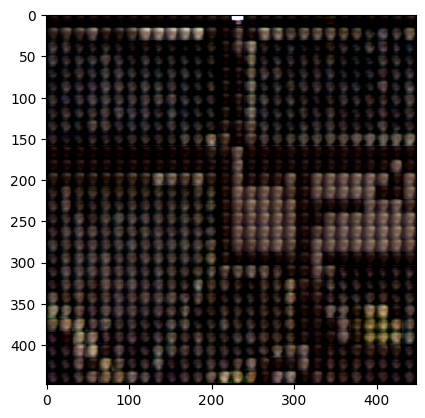

In [59]:
plt.imshow(out_)

In [43]:
output, label = cmap_to_lbl(output, torch.tensor(COLOR_MAP, device=output.device, dtype=output.dtype).unsqueeze(0))
output = output[0].numpy()
label = label[0].numpy()

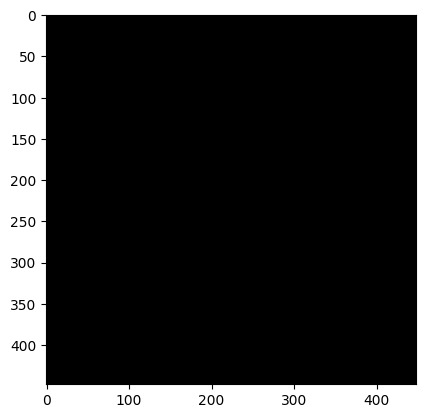

In [44]:
import matplotlib.pyplot as plt
plt.imshow(output)

In [50]:
np.unique(output)

array([0.])